## Rollout trajectory for wbc policy


In [1]:
import jax
from jax import numpy as jp
print("backend:", jax.default_backend())  # should be 'gpu'
print("devices:", jax.devices())          # should list GpuDevice(...)

from brax.training.acme import running_statistics

from mujoco_playground import registry
from mujoco_playground.config import locomotion_params

backend: gpu
devices: [CudaDevice(id=0)]


In [2]:
from hector_pg import constants as consts

ROOT_PATH = consts.ROOT_PATH
env_name = 'HectorWBCFlatTerrain'
policy_path = consts.ROOT_PATH.parent / 'logs' / 'wbc' / 's2_0825_1'

print(policy_path)

env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

print(env._config)

/home/ps/Documents/hector_dev/src/logs/wbc/s2_0825_1
l_hip_yaw: -0.79 to 0.79
l_hip_roll: -0.79 to 0.79
l_hip_pitch: -3.14 to 3.14
l_knee: -3.14 to 3.14
l_ankle: -1.40 to 1.40
r_hip_yaw: -0.79 to 0.79
r_hip_roll: -0.79 to 0.79
r_hip_pitch: -3.14 to 3.14
r_knee: -3.14 to 3.14
r_ankle: -1.40 to 1.40
l_shoulder_yaw: -1.40 to 1.40
l_shoulder_pitch: -3.14 to 1.57
l_shoulder_roll: -1.40 to 1.40
l_elbow: -3.00 to 3.00
r_shoulder_yaw: -1.40 to 1.40
r_shoulder_pitch: -3.14 to 1.57
r_shoulder_roll: -1.40 to 1.40
r_elbow: -3.00 to 3.00
action_repeat: 1
action_scale: 0.75
ang_vel_yaw:
- -1.0
- 1.0
arm_qpos_max:
- 1.4
- 3.14
- 1.4
- 3.0
arm_qpos_min:
- -1.4
- -3.14
- -1.4
- -3.0
body_height:
- 0.4
- 0.65
body_height_default: 0.55
ctrl_dt: 0.02
episode_length: 1000
history_len: 1
impl: jax
lin_vel_x:
- -1.0
- 1.0
lin_vel_y:
- -1.0
- 1.0
nconmax: 65536
njmax: 60
noise_config:
  level: 1.0
  scales:
    acc: 0.2
    faa_pos: 0.03
    ffe_pos: 0.08
    gravity: 0.05
    gyro: 0.2
    hip_pos: 0.03
    

In [3]:
from orbax import checkpoint as ocp
from etils import epath

checkpoint_root = epath.Path(policy_path).expanduser().resolve()

checkpoint_dirs = list(checkpoint_root.glob('*'))
checkpoint_dirs = [ckpt for ckpt in checkpoint_dirs if ckpt.is_dir()]
checkpoint_dirs.sort(key=lambda x: int(x.name))
latest_checkpoint = checkpoint_dirs[-1]
print(f'Loading checkpoint: {latest_checkpoint}')

# Restore
checkpointer = ocp.PyTreeCheckpointer()
loaded_params = checkpointer.restore(latest_checkpoint)

print(loaded_params)

# Fix version mismatch issue from brax
norm_dict = loaded_params[0]
count = norm_dict.get('count', 1)
mean = norm_dict['mean']
std = norm_dict['std']
summed_variance = jax.tree.map(lambda s: jp.square(s) * (count - 1), std)

norm_params = running_statistics.RunningStatisticsState(
    count=count,
    mean=mean,
    summed_variance=summed_variance,
    std=std
)
params = (norm_params, loaded_params[1])

Loading checkpoint: /home/ps/Documents/hector_dev/src/logs/wbc/s2_0825_1/28016640


/home/ps/Documents/hector_dev/.venv/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


[{'count': Array(1.8055168e+08, dtype=float32), 'mean': {'privileged_state': Array([ 1.10611776e-02,  1.32256597e-01, -4.75544203e-03,  2.65042216e-01,
        1.09968051e-01,  9.20780945e+00, -9.73028038e-03, -1.26828095e-02,
       -9.76543605e-01, -2.27535181e-02,  4.05534692e-02, -3.25616486e-02,
       -2.52533972e-01, -1.33937880e-01,  2.79460717e-02,  3.56369205e-02,
       -2.95727346e-02, -1.71449408e-01, -1.42551139e-01,  3.30601865e-03,
       -1.54041557e-03,  8.91141407e-03, -7.02940580e-03, -3.49957310e-02,
       -7.83134077e-04,  2.82793026e-03, -5.05100843e-03,  6.56325230e-03,
       -2.37148311e-02, -1.07661020e-02, -1.57210991e-01,  1.03337280e-01,
       -8.71467683e-03,  5.43857366e-02,  5.98188583e-03, -1.49590880e-01,
        1.37666255e-01, -1.89659297e-02,  2.64979969e-03, -6.02185307e-03,
        2.50688381e-03,  1.55213997e-02, -1.40224036e-03,  8.98940302e-03,
        6.05179882e-03, -3.32572311e-02,  7.75751323e-02, -1.13656297e-02,
       -1.71527471e-02,

In [4]:
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from datetime import datetime
import functools

In [5]:
# Create the inference function with the loaded parameters
network_factory=functools.partial(
  ppo_networks.make_ppo_networks,
  **ppo_params.network_factory,
  # We need to explicitly call the normalization function here since only the brax
  # PPO train.py script creates it if normalize_observations is True.
  preprocess_observations_fn=running_statistics.normalize,
)

ppo_network = network_factory(env.observation_size, env.action_size)
make_inference_fn = ppo_networks.make_inference_fn(ppo_network)
inference_fn = make_inference_fn(params, deterministic=True)

# jit_inference_fn is now ready to be used for rollouts.
jit_inference_fn = jax.jit(inference_fn)
# other jit fcns for rollout, also env for eval
eval_env = registry.load(env_name)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)


l_hip_yaw: -0.79 to 0.79
l_hip_roll: -0.79 to 0.79
l_hip_pitch: -3.14 to 3.14
l_knee: -3.14 to 3.14
l_ankle: -1.40 to 1.40
r_hip_yaw: -0.79 to 0.79
r_hip_roll: -0.79 to 0.79
r_hip_pitch: -3.14 to 3.14
r_knee: -3.14 to 3.14
r_ankle: -1.40 to 1.40
l_shoulder_yaw: -1.40 to 1.40
l_shoulder_pitch: -3.14 to 1.57
l_shoulder_roll: -1.40 to 1.40
l_elbow: -3.00 to 3.00
r_shoulder_yaw: -1.40 to 1.40
r_shoulder_pitch: -3.14 to 1.57
r_shoulder_roll: -1.40 to 1.40
r_elbow: -3.00 to 3.00


In [14]:
#Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command
import numpy as np

rng = jax.random.PRNGKey(1)

# Reset action scale to match policy
eval_env._config.action_scale = 0.75

rollout = []
modify_scene_fns = []

x_vel = 0.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}
body_height = 0.55
body_euler = jp.array([0,0,0])
qarm_left = jp.array([0.0, 0.0, 0.0, 0.0])
qarm_right = jp.array([0.0, 0.0, 0.0, 0.0])
command = jp.array([x_vel, y_vel, yaw_vel, body_height, *body_euler, *qarm_left, *qarm_right])

gait_freq = 1.0 # Hz
phase_dt = 2 * jp.pi * eval_env.dt * gait_freq
phase = jp.array([0, jp.pi])

eval_env._config.push_config.enable=True

for j in range(1):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  for i in range(int(env_cfg.episode_length)):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    if state.done:
      break
    state.info["command"] = command
    
    #state.info["command"].at[3].set( 0.5+0.2*jp.sin(phase[0]) )
    
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env.mj_model.body("torso").id])
    xyz += np.array([0, 0.0, 0])
    print(xyz)
    x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"][0:3], # Mask out other command for rendering
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )


episode 0
[-0.0907324   0.04825391  0.5612802 ]
[-0.08345158  0.04581799  0.5661252 ]
[-0.07639954  0.0436151   0.5689962 ]
[-0.07060886  0.04324185  0.5699178 ]
[-0.06579382  0.04410338  0.56821936]
[-0.06065099  0.045305    0.5664    ]
[-0.05454191  0.04597951  0.5650459 ]
[-0.04754971  0.04579995  0.5621847 ]
[-0.03998454  0.04565888  0.5574399 ]
[-0.03193295  0.04643361  0.552635  ]
[-0.02344877  0.04808085  0.54873395]
[-0.01479804  0.05026396  0.54591835]
[-0.00624289  0.05284684  0.5447227 ]
[0.0023432  0.05570355 0.5449332 ]
[0.01108585 0.05898108 0.5463395 ]
[0.02008053 0.06241295 0.54658866]
[0.02931481 0.06582843 0.54433084]
[0.0388232  0.06919105 0.53992975]
[0.04882173 0.07256287 0.5345473 ]
[0.0588436 0.0760759 0.5317861]
[0.0681711  0.07985651 0.5320278 ]
[0.0768434  0.08409888 0.5352024 ]
[0.08521785 0.08869483 0.539989  ]
[0.09354876 0.09349323 0.5433629 ]
[0.10198471 0.09837101 0.5439713 ]
[0.11070519 0.10314321 0.54226035]
[0.11964484 0.10747544 0.54043263]
[0.127995

In [7]:
# Local ffmpeg
import os
import subprocess

# Add colon separator between paths!
bin_dir = (ROOT_PATH.parent / "visualize" / "ffmpeg" / "ffmpeg-7.0.2-amd64-static")
os.environ["PATH"] = os.pathsep.join([str(bin_dir), os.environ.get("PATH", "")])

print(subprocess.check_output(["ffmpeg", "-version"]).decode())

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-l

In [15]:
import mujoco
import mediapy as media

render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="front",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

fps: 50.0


100%|██████████| 1000/1000 [00:11<00:00, 85.94it/s]


In [9]:
# In case save the rollout visualization
render_every = 1
fps = 1.0 / eval_env.dt / render_every

# 4K UHD = 3840×2160
#frames = eval_env.render(
#    rollout[::render_every],
#    camera="front",
#    scene_option=scene_option,
#    width=1920,
#    height=1080,
#    modify_scene_fns=modify_scene_fns[::render_every],
#)

#import mediapy as media
#from datetime import datetime
#fname = f"video/hector/rollout_{datetime.now():%Y%m%d-%H%M%S}_4k.mp4"

#media.write_video(fname, frames, fps=fps)


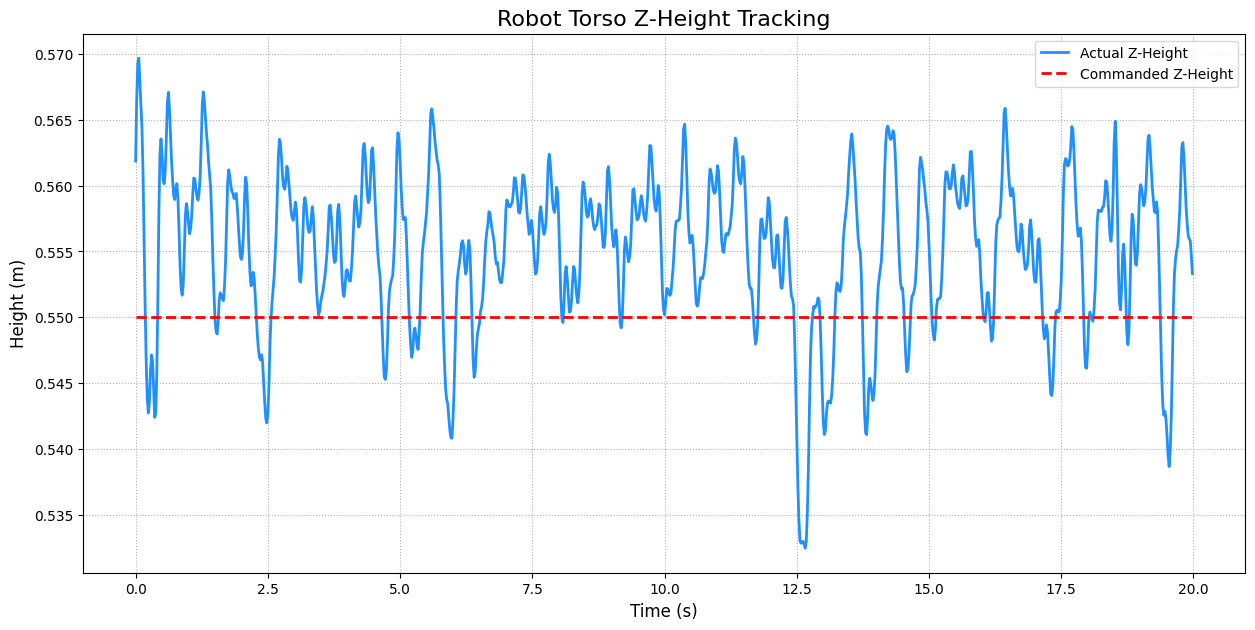

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# This cell assumes 'rollout' and 'eval_env' are available from the previous cell.

# Extract the actual Z-height and commanded Z-height from the rollout data
actual_z_heights = [state.data.qpos[2] for state in rollout]
commanded_z_heights = [state.info['command'][3] for state in rollout]
time_steps = [i * eval_env.dt for i in range(len(rollout))]

# Create the plot
plt.figure(figsize=(15, 7))

# Plot actual and commanded height
plt.plot(time_steps, actual_z_heights, label='Actual Z-Height', color='dodgerblue', linewidth=2)
plt.plot(time_steps, commanded_z_heights, label='Commanded Z-Height', color='red', linestyle='--', linewidth=2)

# Add plot details
plt.title('Robot Torso Z-Height Tracking', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Height (m)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':')
plt.show()